In [1]:
import itertools

import h5py
import yaml
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

import lab.metrics
import lab.analytics

idx = pd.IndexSlice

In [2]:
# Load the sizes from the configuration file
with open("../config/config.yaml", mode="r") as configfile:
    CONFIG = yaml.safe_load(configfile)
display(CONFIG)

{'classifiers': ['dfnet', 'varcnn-time', 'varcnn-sizes', 'p1fp', 'kfp'],
 'n_gpus': {'dfnet': 2,
  'varcnn-time': 2,
  'varcnn-sizes': 2,
  'p1fp': 1,
  'kfp': 0},
 'n_threads': {'dfnet': 2,
  'varcnn-time': 2,
  'varcnn-sizes': 2,
  'p1fp': 2,
  'kfp': 4},
 'thresholds': [1, 130, 175],
 'n_repetitions': 10,
 'script_path': 'scripts/docker-run-experiment',
 'min_packet_size': 175}

In [3]:
def load_results(classifiers: list, repetitions: int, min_sizes: list):
    combinations = list(itertools.product(classifiers, min_sizes, range(repetitions)))
    return pd.concat([
        pd.read_csv(f"../results/{classifier}/predictions-{size}-{rep:02d}.csv",
                    header=0, names=["y_true"] + list(range(-1, 100)))
        for (classifier, size, rep) in combinations
    ], keys=combinations, names=["classifier", "min_size", "run", "sample"]).drop(columns=[-1])


data = load_results(CONFIG["classifiers"], CONFIG["n_repetitions"], CONFIG["thresholds"])
display(data)

y_true             0             1  \
classifier min_size run sample                                       
dfnet      1        0   0         -1.0  2.771017e-06  3.074019e-09   
                        1         -1.0  1.671553e-11  3.426360e-13   
                        2         51.0  5.160465e-11  1.689096e-12   
                        3         -1.0  9.330400e-12  1.781738e-11   
                        4         -1.0  6.757410e-17  4.640288e-19   
...                                ...           ...           ...   
kfp        175      9   5849      -1.0  0.000000e+00  0.000000e+00   
                        5850      42.0  0.000000e+00  0.000000e+00   
                        5851      -1.0  0.000000e+00  0.000000e+00   
                        5852      -1.0  0.000000e+00  0.000000e+00   
                        5853      60.0  0.000000e+00  0.000000e+00   

                                           2             3             4  \
classifier min_size run sample                                             
dfnet      1        0   0       9.301799e-01  4.748701e-07  1.488906e-08   
                        1       2.315033e-13  4.814340e-11  3.719869e-09   
                        2       5.650325e-12  4.609020e-09  4.357676e-14   
                        3       2.386034e-15  1.848699e-16  6.165791e-13   
                        4       2.414027e-26  1.017121e-21  7.670983e-23   
...                                      ...           ...           ...   
kfp        175      9   5849    0.000000e+00  0.000000e+00  0.000000e+00   
                        5850    0.000000e+00  0.000000e+00  0.000000e+00   
                        5851    0.000000e+00  0.000000e+00  0.000000e+00   
                        5852    0.000000e+00  0.000000e+00  0.000000e+00   
                        5853    0.000000e+00  0.000000e+00  0.000000e+00   

                                           5             6             7  \
classifier min_size run sample                                             
dfnet      1        0   0       4.991435e-05  2.171806e-08  1.419927e-08   
                        1       5.753861e-15  7.320879e-09  5.495243e-08   
                        2       4.686558e-14  3.165795e-14  8.968993e-13   
                        3       2.387236e-15  3.324990e-13  2.408385e-14   
                        4       1.114839e-25  3.322915e-25  2.279977e-15   
...                                      ...           ...           ...   
kfp        175      9   5849    0.000000e+00  0.000000e+00  0.000000e+00   
                        5850    0.000000e+00  0.000000e+00  0.000000e+00   
                        5851    0.000000e+00  0.000000e+00  0.000000e+00   
                        5852    0.000000e+00  0.000000e+00  0.000000e+00   
                        5853    0.000000e+00  0.000000e+00  0.000000e+00   

                                           8  ...            90            91  \
classifier min_size run sample                ...                               
dfnet      1        0   0       1.279923e-08  ...  7.005877e-06  3.825294e-08   
                        1       5.175993e-06  ...  5.138659e-11  8.993923e-04   
                        2       5.543967e-15  ...  1.194585e-11  6.128323e-14   
                        3       3.232201e-17  ...  6.852496e-17  1.563061e-18   
                        4       8.630192e-28  ...  2.865838e-29  3.537654e-19   
...                                      ...  ...           ...           ...   
kfp        175      9   5849    0.000000e+00  ...  0.000000e+00  0.000000e+00   
                        5850    0.000000e+00  ...  0.000000e+00  0.000000e+00   
                        5851    0.000000e+00  ...  0.000000e+00  0.000000e+00   
                        5852    0.000000e+00  ...  0.000000e+00  0.000000e+00   
                        5853    0.000000e+00  ...  0.000000e+00  0.000000e+00   

                                          92            93            94  \
classifier mi

In [8]:
def plot_pr_curve(data):
    data = (data
            .transform(lambda x: x*100)
            .rename({"dfnet": "DF", "varcnn-time": "Var-CNN$_T$", "varcnn-sizes": "Var-CNN$_S$", "p1fp": "$p$-FP(C)", "kfp": "$k$-FP"}, axis=0)
            .rename({1: "None", 130: "130 bytes", 175: "175 bytes"}, axis=0)
            .reset_index()
            .rename({"precision": "$\pi_{20}$ (%)", "recall": "Recall (%)", "min_size": "Min. Size"}, axis=1))
    data["Min. Size"] = data["Min. Size"].astype("category")

    with plt.style.context(["./mpl-style/pr-curve.mplstyle", "./mpl-style/pets.mplstyle", {"text.usetex": True}]):
        hue_order = ["130 bytes", "175 bytes", "None"]
        
        grid = sns.relplot(
            data=data, x="Recall (%)", y="$\pi_{20}$ (%)", hue="Min. Size",
            style="Min. Size", col="classifier", kind="line", hue_order=hue_order,
            height=1.125, aspect=1.33, facet_kws=dict(
                legend_out=True, despine=False, gridspec_kws=dict(wspace=.1)
            ), palette="binary", legend=False)
        
        grid.set_titles(col_template="{col_name}")
        
        for i, ax in enumerate(np.ravel(grid.axes)):
            if i == 0:
                ax.legend(labels=hue_order)
            ax.set_xticks([0, 50, 100])
            ax.set_yticks([0, 50, 100])
            ax.xaxis.get_major_formatter()._usetex = False
            ax.yaxis.get_major_formatter()._usetex = False
        
    return grid

/home/jsmith/Projects/quic-traffic-analysis/env/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/home/jsmith/Projects/quic-traffic-analysis/env/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


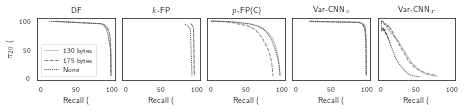

In [9]:
figure = (data.sort_index()
          .groupby(["classifier", "min_size"])
          .apply(lambda df: pd.DataFrame(lab.analytics.rprecision_recall_curve(df["y_true"], df.drop("y_true", axis=1), ratio=20)._asdict()))
          .set_index("thresholds", append=True)
          .pipe(plot_pr_curve))

figure.savefig("../results/plots/score-vs-min-packet-size-prcurve.pdf", dpi=150, bbox_inches="tight")
figure.savefig("../results/plots/score-vs-min-packet-size-prcurve.pgf", dpi=150, bbox_inches="tight")

/home/jsmith/Projects/quic-traffic-analysis/env/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/home/jsmith/Projects/quic-traffic-analysis/env/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


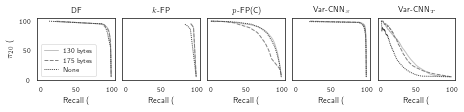

In [10]:
def make_binary_predictions(data):
    data = data.copy()
    data["score"] = data[np.arange(0, 100)].sum(axis=1)
    data["y_true"] = data["y_true"].where(data["y_true"] == -1, 0).astype(int)
    return data[["y_true", "score"]]

figure = (data.sort_index()
          .pipe(make_binary_predictions)
          .groupby(["classifier", "min_size"])
          .apply(lambda df: pd.DataFrame(lab.analytics.rprecision_recall_curve(df["y_true"], df.drop("y_true", axis=1), ratio=20)._asdict()))
          .set_index("thresholds", append=True)
          .pipe(plot_pr_curve))

figure.savefig("../results/plots/score-vs-min-packet-size-prcurve-binary.pdf", dpi=150, bbox_inches="tight")
figure.savefig("../results/plots/score-vs-min-packet-size-prcurve-binary.pgf", dpi=150, bbox_inches="tight")